In [115]:
import pandas as pd
from sktime.datasets import load_gunpoint
from sktime.clustering.k_means import TimeSeriesKMeans
import seaborn as sns
from sktime.utils.plotting import plot_series
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score 

In [144]:
ts = pd.read_csv("ts_transformed.csv")

ts['rating_category'] = ts['rating_category'].replace('Low', 'Medium Low')

# Clustering

## Distance-based Clustering

### Euclidean

In [117]:
ts_numeric = ts.drop(columns=['id', 'rating', 'genre', 'rating_category'])

train, test = train_test_split(ts_numeric, test_size = 2, random_state = 42)

In [111]:
# !pip install tslearn
# !pip install h5py
# !pip install scikit-learn-extra

In [112]:
# from sklearn_extra.cluster import KMedoids
# from tslearn.metrics import cdist_dtw

# # Calcolo matrice di distanza DTW con vincolo Sakoe-Chiba
# dists = cdist_dtw(ts_numeric, global_constraint="sakoe_chiba", sakoe_chiba_radius=4)

# # Clustering con KMedoids
# clusterer = KMedoids(n_clusters=3, metric="precomputed", random_state=0)
# clusterer.fit(dists)
# labels = clusterer.labels_

In [88]:
clusterer = TimeSeriesKMeans(n_clusters=7, metric="euclidean", random_state=42)

In [89]:
# Convertiamo il DataFrame in un array NumPy 3D con forma (n_istanze, 1, n_timepoint)
def convert_to_numpy3D(df):
    return np.expand_dims(df.values, axis=1)

# Applichiamo la conversione
ts_numeric = convert_to_numpy3D(ts_numeric)

clusterer.fit(ts_numeric)

TimeSeriesKMeans(metric='euclidean', n_clusters=7, random_state=42)

In [90]:
clusterer.labels_

array([3, 0, 0, ..., 3, 3, 0], dtype=int64)

In [91]:
ts_numeric = pd.DataFrame(ts_numeric.reshape(1134, 100))
ts_numeric["cluster"] = clusterer.labels_
ts_numeric.head()

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,cluster
0,2.482691,3.103747,3.559498,3.661604,3.738018,1.922693,0.504129,0.340080,0.176768,0.674897,...,-0.668877,-0.801254,-0.939168,-0.914582,-0.889037,-0.855150,-0.814026,-0.719893,-0.618230,3
1,0.755653,1.473569,2.093652,2.228891,2.382833,2.080704,1.754117,0.863556,-0.173753,0.073705,...,0.826150,-0.211159,-1.094527,-0.954972,-0.778011,-0.881598,-0.969359,-0.985185,-1.005327,0
2,2.558031,2.242591,1.877203,1.821367,1.766713,1.143775,0.274846,0.323123,0.381604,0.346184,...,0.003613,-0.043587,-0.076116,-0.060906,-0.042401,-0.014292,0.007560,-0.010648,-0.033158,0
3,3.420437,1.788017,-0.158955,-0.137211,-0.107383,-0.125422,-0.147817,-0.386230,-0.579652,-0.575373,...,-0.231107,-0.266140,-0.295748,-0.367012,-0.418623,-0.403395,-0.381986,-0.232890,0.021629,5
4,4.115150,3.170309,2.253611,2.175913,2.102388,2.173167,2.239405,1.816339,1.449363,1.226049,...,-0.648343,-0.639480,-0.627899,-0.640356,-0.654466,-0.664568,-0.672808,-0.672403,-0.671974,2


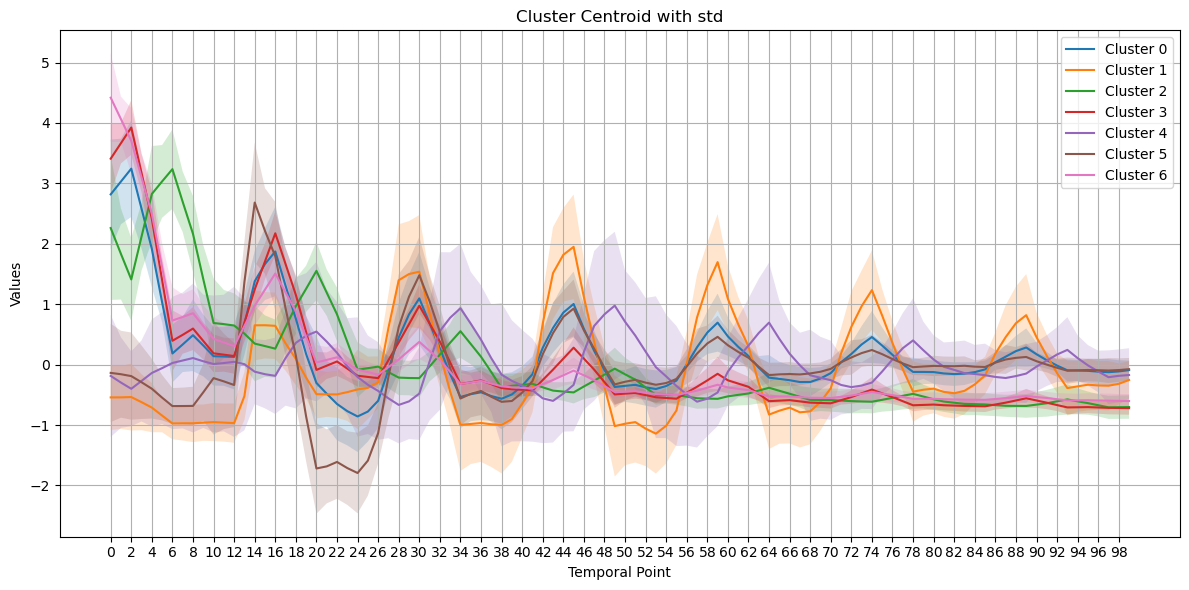

In [104]:
import matplotlib.pyplot as plt
import numpy as np

# Estrai i centroidi
centroids = clusterer.cluster_centers_

# Calcola la deviazione standard per ciascun cluster
std_devs = np.zeros_like(centroids)
for i in range(clusterer.n_clusters):
    # Estrai le serie del cluster i
    cluster_data = ts_numeric[ts_numeric["cluster"] == i].drop(columns=["cluster"]).values
    std_devs[i] = np.std(cluster_data, axis=0)

# Plot
plt.figure(figsize=(12, 6))
for i, centroid in enumerate(centroids):
    mean = centroid.flatten()
    std = std_devs[i].flatten()
    plt.plot(mean, label=f'Cluster {i}')
    plt.fill_between(range(len(mean)), mean - std, mean + std, alpha=0.2)


# Imposta i tick dell'asse x ogni 2 unità
plt.xticks(ticks=np.arange(0, len(mean), 2))

plt.title('Cluster Centroid with std')
plt.xlabel('Temporal Point')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Cluster 0 inizia con valori altri, ricorrenti poi tende ad appiattirsi,  
cluster 1 parte in basso, ma poi ha picchi piu elevati, ricorrenti e continui, ha std elevata  
cluster 2 simile a cluster 0 ma traslato piu avanti  
cluster 3 simile a 0 ma si appiattisce piu rapidamente  
cluster 4 inizia in basso ma poi picchi piu elevati e traslati, ha std elevata in tutti i punti temporali 
cluster 5 inizia in basso, inizialmente ha avuto picchi piu elevati in alto e in basso  
cluster 6 inizia piu in alto, poi valori medi e piatti

In [93]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Melt del DataFrame
# df_melt = ts_numeric.melt(value_name="observation", var_name="time", id_vars="cluster")

# # Usa una palette più colorata (es. 'husl' o 'tab10')
# palette = sns.color_palette("husl", n_colors=df_melt["cluster"].nunique())

# plt.figure(figsize=(18, 6))
# # Line plot
# sns.lineplot(data=df_melt, x="time", y="observation", hue="cluster", palette=palette)
# plt.title("Clustered time series dataset (mean and std)")
# plt.show()

Questo codice serve a visualizzare l'andamento delle serie temporali raggruppate per cluster, usando colori distinti per ogni cluster. È utile per analizzare visivamente come si comportano i diversi gruppi nel tempo.

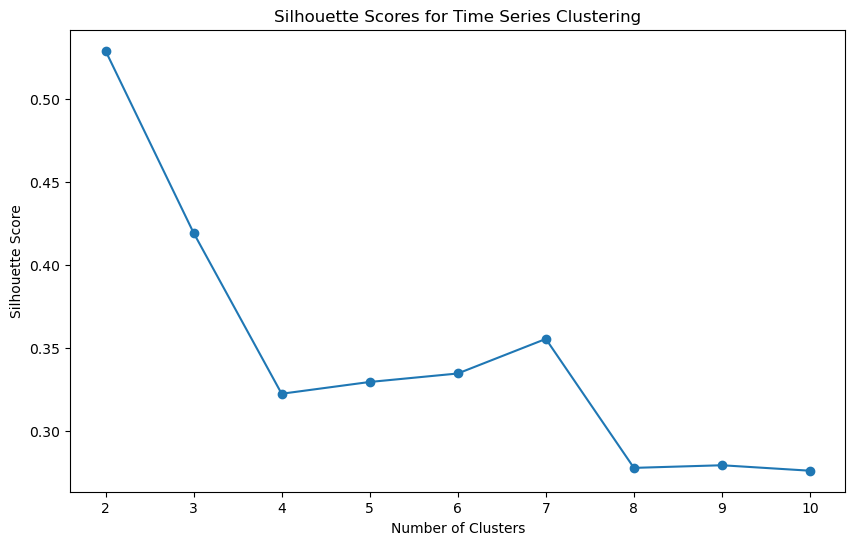

In [94]:
import numpy as np
import pandas as pd
from tslearn.clustering import TimeSeriesKMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Funzione per convertire i dati in formato 3D
def convert_to_numpy3D(data):
    return np.array(data).reshape((data.shape[0], data.shape[1], 1))

# Funzione per calcolare i silhouette score
def compute_silhouette_scores(data, min_clusters=2, max_clusters=10):
    silhouette_scores = []
    data_3d = convert_to_numpy3D(data)
    
    for k in range(min_clusters, max_clusters + 1):
        clusterer = TimeSeriesKMeans(n_clusters=k, metric="euclidean", random_state=42)
        cluster_labels = clusterer.fit_predict(data_3d)
        
        # Calcolo del silhouette score
        score = silhouette_score(data_3d.reshape(data_3d.shape[0], -1), cluster_labels, metric="euclidean")
        silhouette_scores.append(score)
    
    return silhouette_scores

# Calcolo dei silhouette score
silhouette_scores = compute_silhouette_scores(ts_numeric)

# Plot dei risultati
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Time Series Clustering')
plt.show()

In [95]:
silhouette_scores

[0.5290143266602544,
 0.41942614695414276,
 0.32258605884885583,
 0.329672680817103,
 0.33477177152234544,
 0.35558453766515025,
 0.27797310485721416,
 0.2795537704022626,
 0.2762616145613545]

é stato provato sia dtw che euclidean, ma euclidean ha portato a cluster piu separati e definiti rispetto a dtw

### Prova distribuzioni classi

In [96]:
ts["cluster"] = clusterer.labels_
ts

,id,0,1,2,3,4,5,6,7,8,...,94,95,96,97,98,99,rating,genre,rating_category,cluster
0,tt0062622,2.482691,3.103747,3.559498,3.661604,3.738018,1.922693,0.504129,0.340080,0.176768,...,-0.914582,-0.889037,-0.855150,-0.814026,-0.719893,-0.618230,8.3,"['Adventure', 'Sci-Fi']",High,3
1,tt0064816,0.755653,1.473569,2.093652,2.228891,2.382833,2.080704,1.754117,0.863556,-0.173753,...,-0.954972,-0.778011,-0.881598,-0.969359,-0.985185,-1.005327,7.1,"['Crime', 'Drama', 'Romance']",High,0
2,tt0088178,2.558031,2.242591,1.877203,1.821367,1.766713,1.143775,0.274846,0.323123,0.381604,...,-0.060906,-0.042401,-0.014292,0.007560,-0.010648,-0.033158,8.7,"['Documentary', 'Music']",High,0
3,tt0145487,3.420437,1.788017,-0.158955,-0.137211,-0.107383,-0.125422,-0.147817,-0.386230,-0.579652,...,-0.367012,-0.418623,-0.403395,-0.381986,-0.232890,0.021629,7.4,"['Action', 'Adventure', 'Sci-Fi']",High,5
4,tt0359950,4.115150,3.170309,2.253611,2.175913,2.102388,2.173167,2.239405,1.816339,1.449363,...,-0.640356,-0.654466,-0.664568,-0.672808,-0.672403,-0.671974,7.3,"['Adventure', 'Comedy', 'Drama']",High,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1129,tt9731534,4.128610,4.057376,3.979631,3.405842,2.640363,1.627851,0.697029,0.793137,0.894179,...,-0.593716,-0.593558,-0.594604,-0.595935,-0.595623,-0.595360,6.4,"['Horror', 'Mystery', 'Thriller']",Medium,6
1130,tt9735462,2.892057,2.954792,3.024155,2.684483,2.358581,1.641533,0.477102,1.220981,2.835563,...,-0.721303,-0.729668,-0.720145,-0.704252,-0.702901,-0.701872,6.3,"['Biography', 'Comedy', 'Drama']",Medium,6
1131,tt9764362,4.070935,3.795272,3.539188,2.720534,2.070322,1.348375,0.422882,0.576563,0.792893,...,-0.677250,-0.783243,-0.808241,-0.838390,-0.861308,-0.884430,7.2,"['Comedy', 'Horror', 'Thriller']",High,3
1132,tt9784798,2.690397,3.255328,3.753638,4.040744,4.428799,2.689321,0.468972,0.244270,-0.019875,...,-0.586534,-0.584211,-0.605652,-0.629321,-0.619920,-0.611343,7.4,"['Biography', 'Drama', 'History']",High,3


In [97]:
ts['cluster'].unique()

array([3, 0, 5, 2, 6, 1, 4], dtype=int64)

In [98]:
# Calcola statistiche descrittive per ciascun cluster
cluster_stats = ts.groupby('cluster').describe()

# Visualizza le statistiche
cluster_stats


0                                                              \
         count      mean       std       min       25%       50%       75%   
cluster                                                                      
0        101.0  2.818579  0.911372  0.648820  2.331826  2.752876  3.409003   
1        147.0 -0.542628  0.542010 -1.277225 -0.876216 -0.713884 -0.338633   
2         88.0  2.261178  1.197278 -0.794657  1.525823  2.283831  3.194277   
3        324.0  3.409132  0.570329  1.185466  3.054754  3.504137  3.823574   
4         39.0 -0.186689  1.023609 -1.859255 -0.740416 -0.530801  0.076129   
5         44.0 -0.136717  0.824803 -1.430432 -0.619837 -0.296283  0.066009   
6        391.0  4.418797  0.734793  1.874764  4.010069  4.358187  4.833925   

                       1            ...        99           rating            \
              max  count      mean  ...       75%       max  count      mean   
cluster                             ...                                        
0        5.450308  101.0  3.031686  ... -0.014712  0.029155  101.0  6.567327   
1        1.959536  147.0 -0.541941  ... -0.064092  0.833489  147.0  7.261905   
2        4.603085   88.0  1.831105  ... -0.645974  0.038047   88.0  6.546591   
3        4.766910  324.0  3.666754  ... -0.642815 -0.499505  324.0  6.506790   
4        4.014017   39.0 -0.297409  ... -0.041793  1.214300   39.0  7.243590   
5        3.420437   44.0 -0.158835  ...  0.001776  0.054734   44.0  6.959091   
6        7.075269  391.0  4.062702  ... -0.538619  0.000749  391.0  6.300512   

                                            
              std  min  25%  50%  75%  max  
cluster                                     
0        0.954684  4.3  6.0  6.6  7.2  8.7  
1        0.527118  5.3  6.9  7.3  7.6  8.5  
2        0.831278  4.0  6.1  6.5  7.1  8.7  
3        0.825719  4.0  6.0  6.5  7.1  8.5  
4        0.501469  5.9  7.0  7.3  7.5  8.2  
5        0.688550  4.8  6.6  7.0  7.4  8.3  
6        0.949980  2.8  5.7  6.3  6.9  8.5  

[7 rows x 808 columns]

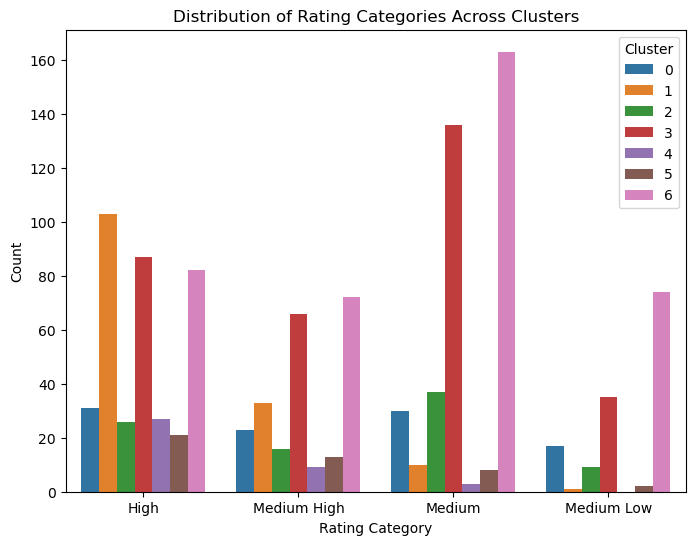

In [99]:

# Explode the 'genre' column to have one genre per row
#ts_exploded = ts.explode('rating_category')

# Plot the distribution of rating categories across clusters
plt.figure(figsize=(8, 6))
sns.countplot(data=ts, x='rating_category', hue='cluster')
plt.title('Distribution of Rating Categories Across Clusters')
plt.xlabel('Rating Category')
plt.ylabel('Count')
plt.legend(title='Cluster')
plt.show()


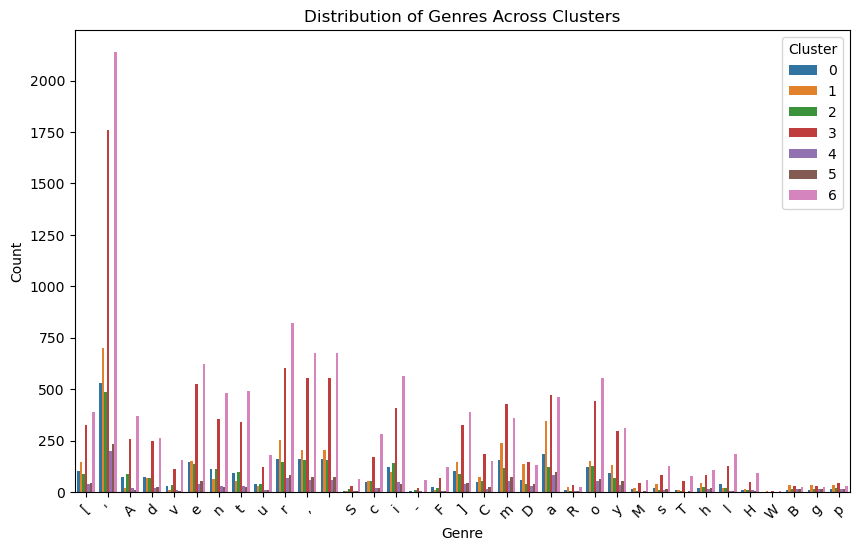

In [100]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Create a list of tuples (cluster, genre)
cluster_genre_list = [(cluster, genre) for cluster, genres in zip(ts['cluster'], ts['genre']) for genre in genres]

# Count the occurrences of each (cluster, genre) pair
cluster_genre_count = Counter(cluster_genre_list)

# Convert the Counter object to a DataFrame for plotting
genre_cluster_df = pd.DataFrame(cluster_genre_count.items(), columns=['cluster_genre', 'count'])
genre_cluster_df[['cluster', 'genre']] = pd.DataFrame(genre_cluster_df['cluster_genre'].tolist(), index=genre_cluster_df.index)
genre_cluster_df = genre_cluster_df.drop(columns=['cluster_genre'])

# Plot the distribution of genres across clusters
plt.figure(figsize=(10, 6))
sns.barplot(data=genre_cluster_df, x='genre', y='count', hue='cluster')
plt.title('Distribution of Genres Across Clusters')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.legend(title='Cluster')
plt.xticks(rotation=45)
plt.show()



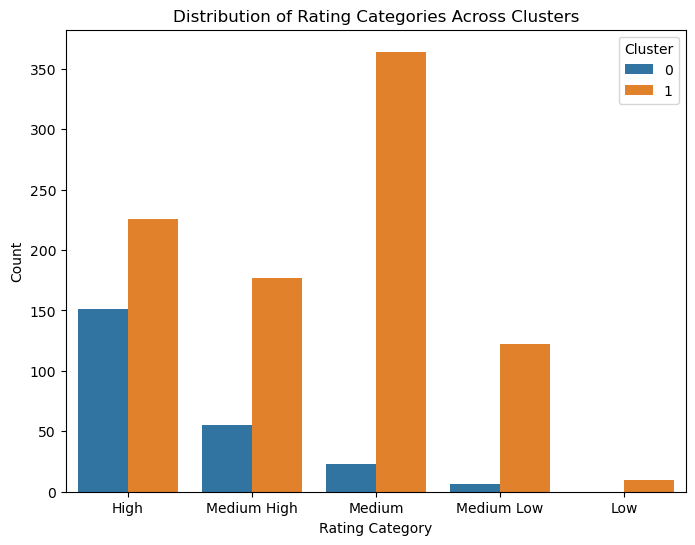

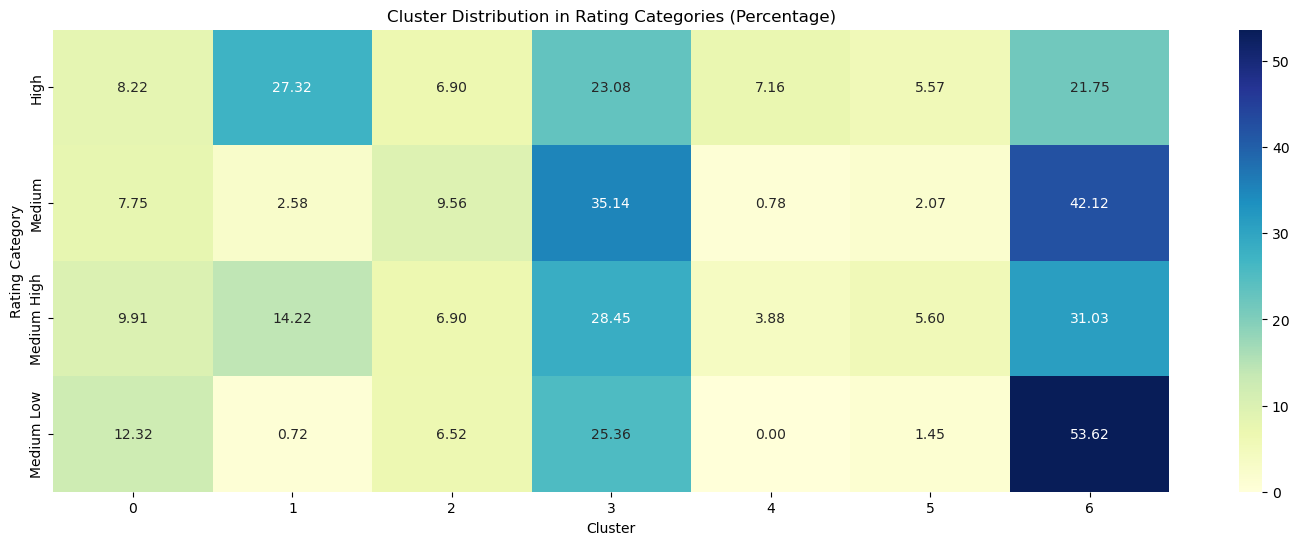


Cluster Purity by Rating Category:
cluster
0    0.322420
1    0.609112
2    0.320018
3    0.313686
4    0.606095
5    0.381441
6    0.361033
dtype: float64


In [101]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Calcola la distribuzione delle categorie di rating per cluster
rating_distribution = ts.groupby(['rating_category', 'cluster']).size().unstack(fill_value=0)

# Converte i conteggi in percentuali rispetto al totale per ciascuna categoria di rating
rating_distribution_percentage = rating_distribution.div(rating_distribution.sum(axis=1), axis=0) * 100

# Crea la heatmap
plt.figure(figsize=(18, 6))
sns.heatmap(rating_distribution_percentage, annot=True, fmt='.2f', cmap='YlGnBu')
plt.title('Cluster Distribution in Rating Categories (Percentage)')
plt.xlabel('Cluster')
plt.ylabel('Rating Category')
plt.show()

# Calculate cluster purity for rating category
rating_purity = rating_distribution_percentage.max(axis=0) / rating_distribution_percentage.sum(axis=0)

print("\nCluster Purity by Rating Category:")
print(rating_purity)

In [102]:
rating_purity.mean()

0.4162579899734401

In [103]:
import pandas as pd
from ast import literal_eval

ts_gen = ts

# Convert the genre column from string representation of list to actual list
ts_gen['genre'] = ts_gen['genre'].apply(literal_eval)

# Create a new DataFrame with binary columns for each genre
genres = set(g for sublist in ts_gen['genre'] for g in sublist)
for genre in genres:
    ts_gen[genre] = ts_gen['genre'].apply(lambda x: 1 if genre in x else 0)

# Drop the original genre column
ts_gen = ts_gen.drop(columns=['genre'])

ts_gen

,id,0,1,2,3,4,5,6,7,8,...,Drama,Adventure,Biography,Musical,Music,Fantasy,Action,Horror,Comedy,Mystery
0,tt0062622,2.482691,3.103747,3.559498,3.661604,3.738018,1.922693,0.504129,0.340080,0.176768,...,0,1,0,0,0,0,0,0,0,0
1,tt0064816,0.755653,1.473569,2.093652,2.228891,2.382833,2.080704,1.754117,0.863556,-0.173753,...,1,0,0,0,0,0,0,0,0,0
2,tt0088178,2.558031,2.242591,1.877203,1.821367,1.766713,1.143775,0.274846,0.323123,0.381604,...,0,0,0,0,1,0,0,0,0,0
3,tt0145487,3.420437,1.788017,-0.158955,-0.137211,-0.107383,-0.125422,-0.147817,-0.386230,-0.579652,...,0,1,0,0,0,0,1,0,0,0
4,tt0359950,4.115150,3.170309,2.253611,2.175913,2.102388,2.173167,2.239405,1.816339,1.449363,...,1,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1129,tt9731534,4.128610,4.057376,3.979631,3.405842,2.640363,1.627851,0.697029,0.793137,0.894179,...,0,0,0,0,0,0,0,1,0,1
1130,tt9735462,2.892057,2.954792,3.024155,2.684483,2.358581,1.641533,0.477102,1.220981,2.835563,...,1,0,1,0,0,0,0,0,1,0
1131,tt9764362,4.070935,3.795272,3.539188,2.720534,2.070322,1.348375,0.422882,0.576563,0.792893,...,0,0,0,0,0,0,0,1,1,0
1132,tt9784798,2.690397,3.255328,3.753638,4.040744,4.428799,2.689321,0.468972,0.244270,-0.019875,...,1,0,1,0,0,0,0,0,0,0


In [95]:

ts_gen.iloc[:, -22:]


,Sci-Fi,Biography,Documentary,Drama,Western,War,Adventure,Fantasy,Romance,Crime,...,Horror,Mystery,Musical,Sport,Animation,Family,History,Music,Short,Action
0,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1129,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
1130,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1131,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1132,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [96]:
ts_gen.columns

Index(['id', '0', '1', '2', '3', '4', '5', '6', '7', '8',
       ...
       'Horror', 'Mystery', 'Musical', 'Sport', 'Animation', 'Family',
       'History', 'Music', 'Short', 'Action'],
      dtype='object', length=126)

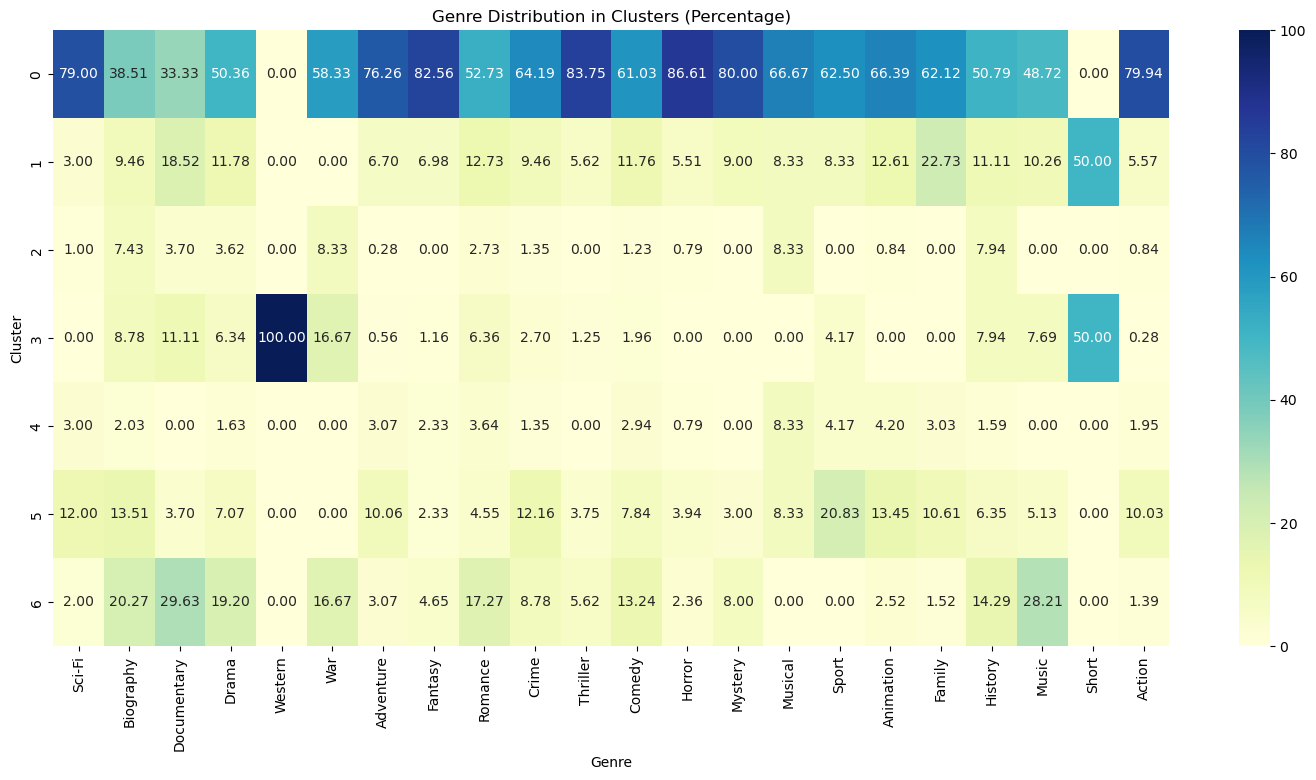

Cluster Purity by Genre:
cluster
0    0.067467
1    0.208803
2    0.172143
3    0.440578
4    0.189217
5    0.131337
6    0.149123
dtype: float64


In [97]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Calcola la distribuzione dei generi per cluster
genre_columns = ts_gen.columns[-22:]
genre_distribution = ts_gen.groupby('cluster')[genre_columns].sum()

# Converte i conteggi in percentuali rispetto al totale per ciascun genere
genre_distribution_percentage = genre_distribution.div(genre_distribution.sum(axis=0), axis=1) * 100

# Crea la heatmap
plt.figure(figsize=(18, 8))
sns.heatmap(genre_distribution_percentage, annot=True, fmt='.2f', cmap='YlGnBu')
plt.title('Genre Distribution in Clusters (Percentage)')
plt.xlabel('Genre')
plt.ylabel('Cluster')
plt.show()

# Calcola la purity per ciascun genere
genre_purity = genre_distribution_percentage.max(axis=1) / genre_distribution_percentage.sum(axis=1)

print("Cluster Purity by Genre:")
print(genre_purity)

In [98]:
genre_purity.mean()

0.1940955392363363

## Feature Based

### TSFresh

In [105]:
# !pip install -r requirements.txt

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached numba-0.61.2-cp311-cp311-win_amd64.whl.metadata (2.9 kB)
  Using cached llvmlite-0.44.0-cp311-cp311-win_amd64.whl.metadata (5.0 kB)
  Using cached numpy-1.26.4-cp311-cp311-win_amd64.whl.metadata (61 kB)
INFO: pip is looking at multiple versions of thinc to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of thinc to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to pr

  error: subprocess-exited-with-error
  
  × Building wheel for pycatch22 (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [57 lines of output]
      C:\Users\Lavigi\AppData\Local\Temp\pip-build-env-vu_uznsd\overlay\Lib\site-packages\setuptools\config\_apply_pyprojecttoml.py:82: SetuptoolsDeprecationWarning: `project.license` as a TOML table is deprecated
      !!
      
              ********************************************************************************
              Please use a simple string containing a SPDX expression for `project.license`. You can also use `project.license-files`. (Both options available on setuptools>=77.0.0).
      
              By 2026-Feb-18, you need to update your project and remove deprecated calls
              or your builds will no longer be supported.
      
              See https://packaging.python.org/en/latest/guides/writing-pyproject-toml/#license for details.
              **********************************************

In [5]:
from sktime.transformations.panel.tsfresh import TSFreshFeatureExtractor

In [11]:
ts_f = TSFreshFeatureExtractor(default_fc_parameters="comprehensive", show_warnings=False, disable_progressbar=True)

# Convertiamo il DataFrame in un array NumPy 3D con forma (n_istanze, 1, n_timepoint)
def convert_to_numpy3D(df):
    return np.expand_dims(df.values, axis=1)

# Applichiamo la conversione
ts_numeric = convert_to_numpy3D(ts_numeric)

ts_ftransform = ts_f.fit_transform(ts_numeric)
ts_ftransform

,var_0__variance_larger_than_standard_deviation,var_0__has_duplicate_max,var_0__has_duplicate_min,var_0__has_duplicate,var_0__sum_values,var_0__abs_energy,var_0__mean_abs_change,var_0__mean_change,var_0__mean_second_derivative_central,var_0__median,...,var_0__fourier_entropy__bins_5,var_0__fourier_entropy__bins_10,var_0__fourier_entropy__bins_100,var_0__permutation_entropy__dimension_3__tau_1,var_0__permutation_entropy__dimension_4__tau_1,var_0__permutation_entropy__dimension_5__tau_1,var_0__permutation_entropy__dimension_6__tau_1,var_0__permutation_entropy__dimension_7__tau_1,var_0__query_similarity_count__query_None__threshold_0.0,var_0__mean_n_absolute_max__number_of_maxima_7
0,0.0,0.0,0.0,0.0,6.217249e-15,99.000000,0.282349,-0.031322,-0.002650,-0.198324,...,0.481199,0.761938,1.798421,1.486533,2.348272,3.195896,3.914061,4.257520,0.0,2.823046
1,0.0,0.0,0.0,1.0,-2.220446e-16,99.000000,0.370024,-0.017788,-0.003766,-0.344959,...,0.575228,1.118198,2.064832,1.458521,2.279099,3.081381,3.798828,4.190274,0.0,2.414896
2,0.0,0.0,0.0,0.0,1.782011e+01,54.262133,0.146584,-0.026174,0.001495,0.036319,...,0.604187,0.929743,1.310476,1.463895,2.295930,3.063555,3.726477,4.169223,0.0,2.098965
3,1.0,0.0,0.0,0.0,2.397208e+00,111.916867,0.467317,-0.034331,0.009627,-0.301354,...,0.319026,0.518641,1.220334,1.242043,1.833542,2.342994,2.806321,3.178314,0.0,2.935552
4,0.0,0.0,0.0,0.0,3.663736e-15,99.000000,0.116081,-0.048355,0.004823,-0.494929,...,0.192626,0.192626,0.810494,1.391749,2.147101,2.824659,3.407815,3.878619,0.0,2.604278
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1129,0.0,0.0,0.0,0.0,1.665335e-15,99.000000,0.096308,-0.047717,0.000365,-0.452917,...,0.192626,0.192626,0.545824,1.336025,2.042741,2.690190,3.236161,3.672530,0.0,3.068717
1130,0.0,0.0,0.0,1.0,4.329870e-15,99.000000,0.173610,-0.036302,-0.000315,-0.630160,...,0.192626,0.288342,0.761435,1.474770,2.320502,3.066160,3.802100,4.179141,0.0,2.659794
1131,0.0,0.0,0.0,0.0,1.776357e-15,99.000000,0.180034,-0.050054,0.001288,-0.428689,...,0.356468,0.451359,1.102479,1.353975,2.073170,2.680802,3.207523,3.614821,0.0,2.870955
1132,0.0,0.0,0.0,1.0,1.110223e-16,99.000000,0.167555,-0.033351,-0.002839,-0.335559,...,0.288342,0.383650,0.854598,1.443981,2.191501,2.943808,3.546587,3.844293,0.0,3.240705


In [34]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
ts_fscaled = scaler.fit_transform(ts_ftransform)

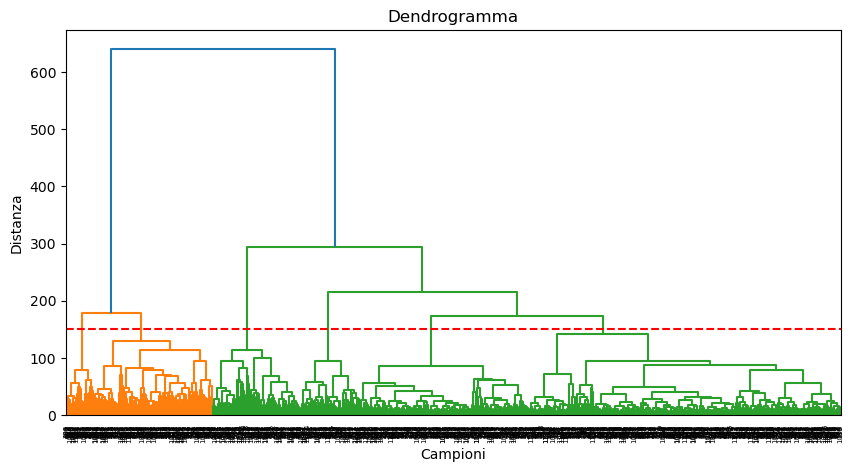

Cluster ottenuti con taglio a 1.5: [3 3 3 ... 6 5 3]


In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt

# Calcolo del linkage
Z = linkage(ts_fscaled, method='ward')

# Visualizzazione del dendrogramma
plt.figure(figsize=(10, 5))
dendrogram(Z)
plt.title("Dendrogram")
plt.xlabel("Units")
plt.ylabel("Distance")

# Aggiunta della linea orizzontale all'altezza 1.5
plt.axhline(y=150, color='r', linestyle='--')

plt.show()

# Taglio del dendrogramma per ottenere i cluster
clusters_g = fcluster(Z, t= 150, criterion='distance')

# Valutazione dei cluster ottenuti
print(f"Cluster ottenuti con taglio a 1.5: {clusters_g}")

In [38]:
ts_g = ts
ts_g["cluster"] = clusters_g
ts_g

,id,0,1,2,3,4,5,6,7,8,...,94,95,96,97,98,99,rating,genre,rating_category,cluster
0,tt0062622,2.482691,3.103747,3.559498,3.661604,3.738018,1.922693,0.504129,0.340080,0.176768,...,-0.914582,-0.889037,-0.855150,-0.814026,-0.719893,-0.618230,8.3,"['Adventure', 'Sci-Fi']",High,3
1,tt0064816,0.755653,1.473569,2.093652,2.228891,2.382833,2.080704,1.754117,0.863556,-0.173753,...,-0.954972,-0.778011,-0.881598,-0.969359,-0.985185,-1.005327,7.1,"['Crime', 'Drama', 'Romance']",High,3
2,tt0088178,2.558031,2.242591,1.877203,1.821367,1.766713,1.143775,0.274846,0.323123,0.381604,...,-0.060906,-0.042401,-0.014292,0.007560,-0.010648,-0.033158,8.7,"['Documentary', 'Music']",High,3
3,tt0145487,3.420437,1.788017,-0.158955,-0.137211,-0.107383,-0.125422,-0.147817,-0.386230,-0.579652,...,-0.367012,-0.418623,-0.403395,-0.381986,-0.232890,0.021629,7.4,"['Action', 'Adventure', 'Sci-Fi']",High,3
4,tt0359950,4.115150,3.170309,2.253611,2.175913,2.102388,2.173167,2.239405,1.816339,1.449363,...,-0.640356,-0.654466,-0.664568,-0.672808,-0.672403,-0.671974,7.3,"['Adventure', 'Comedy', 'Drama']",High,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1129,tt9731534,4.128610,4.057376,3.979631,3.405842,2.640363,1.627851,0.697029,0.793137,0.894179,...,-0.593716,-0.593558,-0.594604,-0.595935,-0.595623,-0.595360,6.4,"['Horror', 'Mystery', 'Thriller']",Medium,6
1130,tt9735462,2.892057,2.954792,3.024155,2.684483,2.358581,1.641533,0.477102,1.220981,2.835563,...,-0.721303,-0.729668,-0.720145,-0.704252,-0.702901,-0.701872,6.3,"['Biography', 'Comedy', 'Drama']",Medium,6
1131,tt9764362,4.070935,3.795272,3.539188,2.720534,2.070322,1.348375,0.422882,0.576563,0.792893,...,-0.677250,-0.783243,-0.808241,-0.838390,-0.861308,-0.884430,7.2,"['Comedy', 'Horror', 'Thriller']",High,6
1132,tt9784798,2.690397,3.255328,3.753638,4.040744,4.428799,2.689321,0.468972,0.244270,-0.019875,...,-0.586534,-0.584211,-0.605652,-0.629321,-0.619920,-0.611343,7.4,"['Biography', 'Drama', 'History']",High,5


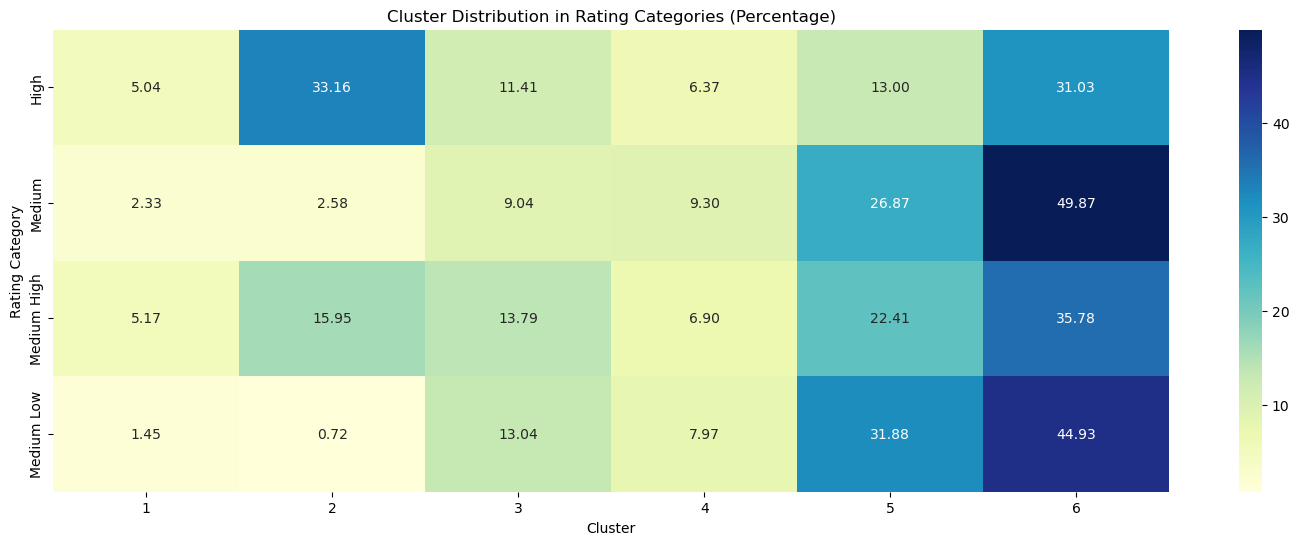


Cluster Purity by Rating Category:
cluster
1    0.369800
2    0.632596
3    0.291693
4    0.304635
5    0.338585
6    0.308590
dtype: float64


In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Calcola la distribuzione delle categorie di rating per cluster
rating_distribution = ts_g.groupby(['rating_category', 'cluster']).size().unstack(fill_value=0)

# Converte i conteggi in percentuali rispetto al totale per ciascuna categoria di rating
rating_distribution_percentage = rating_distribution.div(rating_distribution.sum(axis=1), axis=0) * 100

# Crea la heatmap
plt.figure(figsize=(18, 6))
sns.heatmap(rating_distribution_percentage, annot=True, fmt='.2f', cmap='YlGnBu')
plt.title('Cluster Distribution in Rating Categories (Percentage)')
plt.xlabel('Cluster')
plt.ylabel('Rating Category')
plt.show()

# Calculate cluster purity for rating category
rating_purity = rating_distribution_percentage.max(axis=0) / rating_distribution_percentage.sum(axis=0)

print("\nCluster Purity by Rating Category:")
print(rating_purity)

In [40]:
rating_purity.mean()

0.374316520988547

In [41]:
import pandas as pd
from ast import literal_eval

ts_gen = ts_g

# Convert the genre column from string representation of list to actual list
ts_gen['genre'] = ts_gen['genre'].apply(literal_eval)

# Create a new DataFrame with binary columns for each genre
genres = set(g for sublist in ts_gen['genre'] for g in sublist)
for genre in genres:
    ts_gen[genre] = ts_gen['genre'].apply(lambda x: 1 if genre in x else 0)

# Drop the original genre column
ts_gen = ts_gen.drop(columns=['genre'])

ts_gen

,id,0,1,2,3,4,5,6,7,8,...,Horror,Western,Sport,Family,Biography,Short,Action,War,Music,Mystery
0,tt0062622,2.482691,3.103747,3.559498,3.661604,3.738018,1.922693,0.504129,0.340080,0.176768,...,0,0,0,0,0,0,0,0,0,0
1,tt0064816,0.755653,1.473569,2.093652,2.228891,2.382833,2.080704,1.754117,0.863556,-0.173753,...,0,0,0,0,0,0,0,0,0,0
2,tt0088178,2.558031,2.242591,1.877203,1.821367,1.766713,1.143775,0.274846,0.323123,0.381604,...,0,0,0,0,0,0,0,0,1,0
3,tt0145487,3.420437,1.788017,-0.158955,-0.137211,-0.107383,-0.125422,-0.147817,-0.386230,-0.579652,...,0,0,0,0,0,0,1,0,0,0
4,tt0359950,4.115150,3.170309,2.253611,2.175913,2.102388,2.173167,2.239405,1.816339,1.449363,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1129,tt9731534,4.128610,4.057376,3.979631,3.405842,2.640363,1.627851,0.697029,0.793137,0.894179,...,1,0,0,0,0,0,0,0,0,1
1130,tt9735462,2.892057,2.954792,3.024155,2.684483,2.358581,1.641533,0.477102,1.220981,2.835563,...,0,0,0,0,1,0,0,0,0,0
1131,tt9764362,4.070935,3.795272,3.539188,2.720534,2.070322,1.348375,0.422882,0.576563,0.792893,...,1,0,0,0,0,0,0,0,0,0
1132,tt9784798,2.690397,3.255328,3.753638,4.040744,4.428799,2.689321,0.468972,0.244270,-0.019875,...,0,0,0,0,1,0,0,0,0,0


In [42]:

ts_gen.iloc[:, -22:]


,Sci-Fi,Romance,History,Adventure,Comedy,Fantasy,Thriller,Drama,Documentary,Animation,...,Horror,Western,Sport,Family,Biography,Short,Action,War,Music,Mystery
0,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
3,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,0,0,1,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1129,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,1
1130,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
1131,0,0,0,0,1,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1132,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0


In [43]:
ts_gen.columns

Index(['id', '0', '1', '2', '3', '4', '5', '6', '7', '8',
       ...
       'Horror', 'Western', 'Sport', 'Family', 'Biography', 'Short', 'Action',
       'War', 'Music', 'Mystery'],
      dtype='object', length=126)

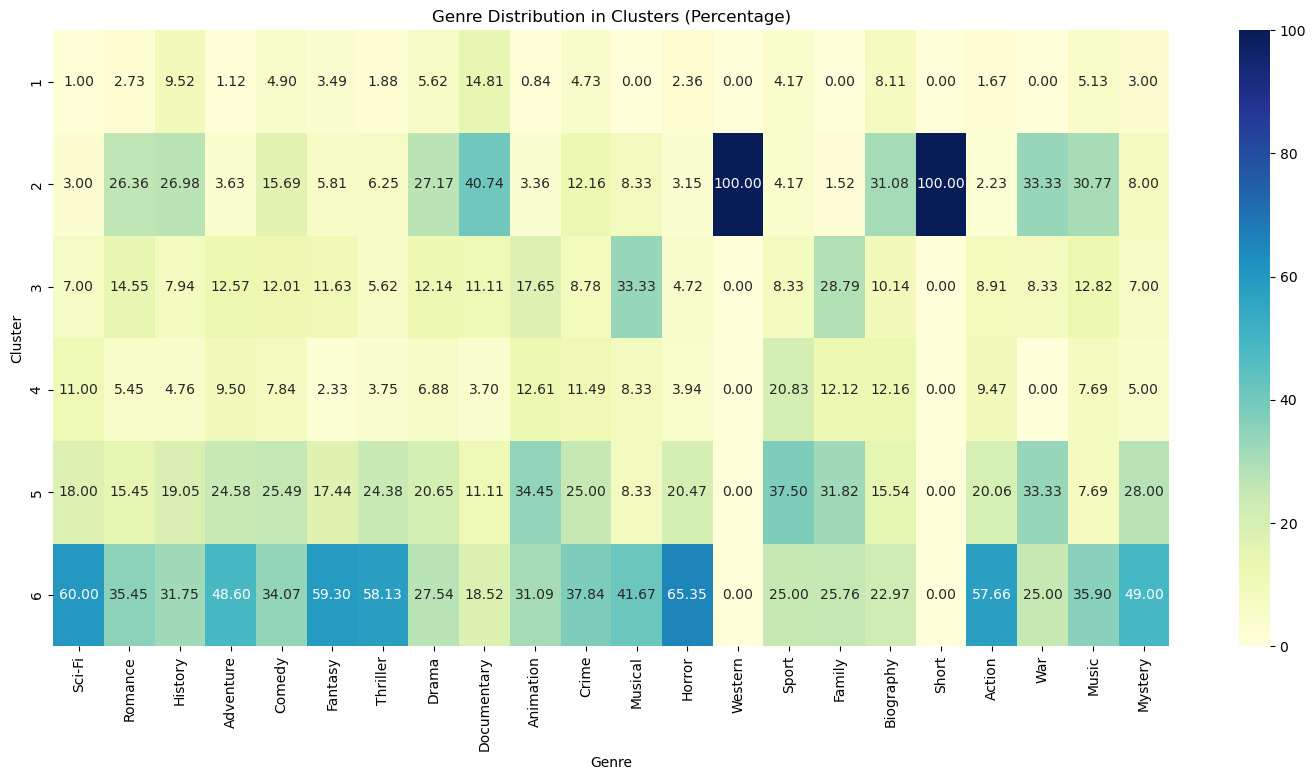

Cluster Purity by Genre:
cluster
1    0.197344
2    0.202534
3    0.136962
4    0.131141
5    0.085547
6    0.082665
dtype: float64


In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Calcola la distribuzione dei generi per cluster
genre_columns = ts_gen.columns[-22:]
genre_distribution = ts_gen.groupby('cluster')[genre_columns].sum()

# Converte i conteggi in percentuali rispetto al totale per ciascun genere
genre_distribution_percentage = genre_distribution.div(genre_distribution.sum(axis=0), axis=1) * 100

# Crea la heatmap
plt.figure(figsize=(18, 8))
sns.heatmap(genre_distribution_percentage, annot=True, fmt='.2f', cmap='YlGnBu')
plt.title('Genre Distribution in Clusters (Percentage)')
plt.xlabel('Genre')
plt.ylabel('Cluster')
plt.show()

# Calcola la purity per ciascun genere
genre_purity = genre_distribution_percentage.max(axis=1) / genre_distribution_percentage.sum(axis=1)

print("Cluster Purity by Genre:")
print(genre_purity)

In [45]:
genre_purity.mean()

0.13936565368031592

### WITH PCA

In [118]:
from sktime.transformations.panel.tsfresh import TSFreshFeatureExtractor

In [ ]:
ts_f = TSFreshFeatureExtractor(default_fc_parameters="comprehensive", show_warnings=False, disable_progressbar=True)

# Convertiamo il DataFrame in un array NumPy 3D con forma (n_istanze, 1, n_timepoint)
def convert_to_numpy3D(df):
    return np.expand_dims(df.values, axis=1)

# Applichiamo la conversione
ts_numeric = convert_to_numpy3D(ts_numeric)



AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [135]:
ts_ftransform = ts_f.fit_transform(ts_numeric)
ts_ftransform

,var_0__variance_larger_than_standard_deviation,var_0__has_duplicate_max,var_0__has_duplicate_min,var_0__has_duplicate,var_0__sum_values,var_0__abs_energy,var_0__mean_abs_change,var_0__mean_change,var_0__mean_second_derivative_central,var_0__median,...,var_0__fourier_entropy__bins_5,var_0__fourier_entropy__bins_10,var_0__fourier_entropy__bins_100,var_0__permutation_entropy__dimension_3__tau_1,var_0__permutation_entropy__dimension_4__tau_1,var_0__permutation_entropy__dimension_5__tau_1,var_0__permutation_entropy__dimension_6__tau_1,var_0__permutation_entropy__dimension_7__tau_1,var_0__query_similarity_count__query_None__threshold_0.0,var_0__mean_n_absolute_max__number_of_maxima_7
0,0.0,0.0,0.0,0.0,6.217249e-15,99.000000,0.282349,-0.031322,-0.002650,-0.198324,...,0.481199,0.761938,1.798421,1.486533,2.348272,3.195896,3.914061,4.257520,0.0,2.823046
1,0.0,0.0,0.0,1.0,-2.220446e-16,99.000000,0.370024,-0.017788,-0.003766,-0.344959,...,0.575228,1.118198,2.064832,1.458521,2.279099,3.081381,3.798828,4.190274,0.0,2.414896
2,0.0,0.0,0.0,0.0,1.782011e+01,54.262133,0.146584,-0.026174,0.001495,0.036319,...,0.604187,0.929743,1.310476,1.463895,2.295930,3.063555,3.726477,4.169223,0.0,2.098965
3,1.0,0.0,0.0,0.0,2.397208e+00,111.916867,0.467317,-0.034331,0.009627,-0.301354,...,0.319026,0.518641,1.220334,1.242043,1.833542,2.342994,2.806321,3.178314,0.0,2.935552
4,0.0,0.0,0.0,0.0,3.663736e-15,99.000000,0.116081,-0.048355,0.004823,-0.494929,...,0.192626,0.192626,0.810494,1.391749,2.147101,2.824659,3.407815,3.878619,0.0,2.604278
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1129,0.0,0.0,0.0,0.0,1.665335e-15,99.000000,0.096308,-0.047717,0.000365,-0.452917,...,0.192626,0.192626,0.545824,1.336025,2.042741,2.690190,3.236161,3.672530,0.0,3.068717
1130,0.0,0.0,0.0,1.0,4.329870e-15,99.000000,0.173610,-0.036302,-0.000315,-0.630160,...,0.192626,0.288342,0.761435,1.474770,2.320502,3.066160,3.802100,4.179141,0.0,2.659794
1131,0.0,0.0,0.0,0.0,1.776357e-15,99.000000,0.180034,-0.050054,0.001288,-0.428689,...,0.356468,0.451359,1.102479,1.353975,2.073170,2.680802,3.207523,3.614821,0.0,2.870955
1132,0.0,0.0,0.0,1.0,1.110223e-16,99.000000,0.167555,-0.033351,-0.002839,-0.335559,...,0.288342,0.383650,0.854598,1.443981,2.191501,2.943808,3.546587,3.844293,0.0,3.240705


In [136]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
ts_fscaled = scaler.fit_transform(ts_ftransform)

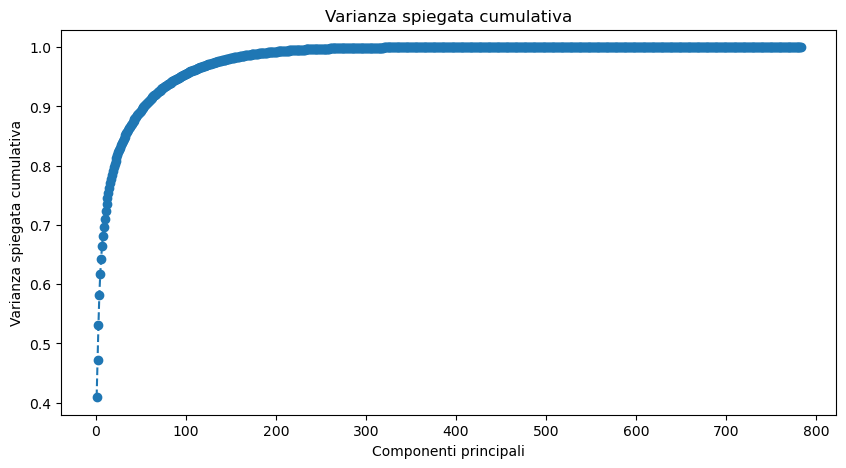

Componente 1: 0.4093
Componente 2: 0.4729
Componente 3: 0.5304
Componente 4: 0.5816
Componente 5: 0.6171
Componente 6: 0.6431
Componente 7: 0.6648
Componente 8: 0.6818
Componente 9: 0.6972
Componente 10: 0.7105
Componente 11: 0.7232
Componente 12: 0.7352
Componente 13: 0.7454
Componente 14: 0.7546
Componente 15: 0.7630
Componente 16: 0.7707
Componente 17: 0.7782
Componente 18: 0.7851
Componente 19: 0.7916
Componente 20: 0.7975
Componente 21: 0.8031
Componente 22: 0.8086
Componente 23: 0.8136
Componente 24: 0.8183
Componente 25: 0.8227
Componente 26: 0.8268
Componente 27: 0.8307
Componente 28: 0.8345
Componente 29: 0.8381
Componente 30: 0.8415
Componente 31: 0.8449
Componente 32: 0.8482
Componente 33: 0.8514
Componente 34: 0.8545
Componente 35: 0.8575
Componente 36: 0.8605
Componente 37: 0.8633
Componente 38: 0.8660
Componente 39: 0.8686
Componente 40: 0.8711
Componente 41: 0.8735
Componente 42: 0.8759
Componente 43: 0.8782
Componente 44: 0.8805
Componente 45: 0.8827
Componente 46: 0.88

In [137]:
# PCA
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Esegui PCA
pca = PCA()
ts_pca = pca.fit_transform(ts_fscaled)

# Varianza spiegata per ciascuna componente
explained_variance = pca.explained_variance_ratio_

# Varianza spiegata cumulativa
cumulative_variance = explained_variance.cumsum()

# Grafico della varianza spiegata cumulativa
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Varianza spiegata cumulativa')
plt.xlabel('Componenti principali')
plt.ylabel('Varianza spiegata cumulativa')
plt.show()

# Stampa la varianza spiegata cumulativa
for i, var in enumerate(cumulative_variance):
    print(f"Componente {i+1}: {var:.4f}")

In [138]:
# PCA
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Esegui PCA
pca = PCA(n_components=6)
ts_pca = pca.fit_transform(ts_fscaled)

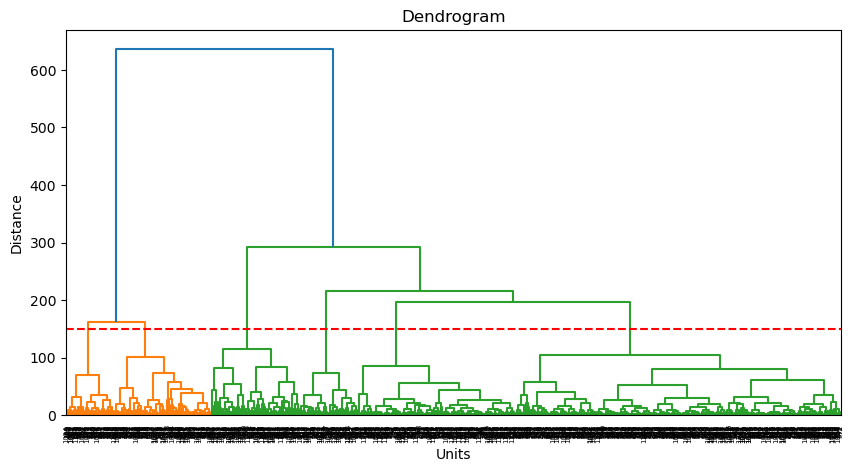

Cluster ottenuti con taglio a 1.5: [3 2 3 ... 6 6 3]


In [139]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt

# Calcolo del linkage
Z = linkage(ts_pca, method='ward')

# Visualizzazione del dendrogramma
plt.figure(figsize=(10, 5))
dendrogram(Z)
plt.title("Dendrogram")
plt.xlabel("Units")
plt.ylabel("Distance")

# Aggiunta della linea orizzontale all'altezza 1.5
plt.axhline(y=150, color='r', linestyle='--')

plt.show()

# Taglio del dendrogramma per ottenere i cluster
clusters_g = fcluster(Z, t= 150, criterion='distance')

# Valutazione dei cluster ottenuti
print(f"Cluster ottenuti con taglio a 1.5: {clusters_g}")

In [145]:
ts_g = ts
ts_g["cluster"] = clusters_g
ts_g

,id,0,1,2,3,4,5,6,7,8,...,94,95,96,97,98,99,rating,genre,rating_category,cluster
0,tt0062622,2.482691,3.103747,3.559498,3.661604,3.738018,1.922693,0.504129,0.340080,0.176768,...,-0.914582,-0.889037,-0.855150,-0.814026,-0.719893,-0.618230,8.3,"['Adventure', 'Sci-Fi']",High,3
1,tt0064816,0.755653,1.473569,2.093652,2.228891,2.382833,2.080704,1.754117,0.863556,-0.173753,...,-0.954972,-0.778011,-0.881598,-0.969359,-0.985185,-1.005327,7.1,"['Crime', 'Drama', 'Romance']",High,2
2,tt0088178,2.558031,2.242591,1.877203,1.821367,1.766713,1.143775,0.274846,0.323123,0.381604,...,-0.060906,-0.042401,-0.014292,0.007560,-0.010648,-0.033158,8.7,"['Documentary', 'Music']",High,3
3,tt0145487,3.420437,1.788017,-0.158955,-0.137211,-0.107383,-0.125422,-0.147817,-0.386230,-0.579652,...,-0.367012,-0.418623,-0.403395,-0.381986,-0.232890,0.021629,7.4,"['Action', 'Adventure', 'Sci-Fi']",High,2
4,tt0359950,4.115150,3.170309,2.253611,2.175913,2.102388,2.173167,2.239405,1.816339,1.449363,...,-0.640356,-0.654466,-0.664568,-0.672808,-0.672403,-0.671974,7.3,"['Adventure', 'Comedy', 'Drama']",High,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1129,tt9731534,4.128610,4.057376,3.979631,3.405842,2.640363,1.627851,0.697029,0.793137,0.894179,...,-0.593716,-0.593558,-0.594604,-0.595935,-0.595623,-0.595360,6.4,"['Horror', 'Mystery', 'Thriller']",Medium,5
1130,tt9735462,2.892057,2.954792,3.024155,2.684483,2.358581,1.641533,0.477102,1.220981,2.835563,...,-0.721303,-0.729668,-0.720145,-0.704252,-0.702901,-0.701872,6.3,"['Biography', 'Comedy', 'Drama']",Medium,6
1131,tt9764362,4.070935,3.795272,3.539188,2.720534,2.070322,1.348375,0.422882,0.576563,0.792893,...,-0.677250,-0.783243,-0.808241,-0.838390,-0.861308,-0.884430,7.2,"['Comedy', 'Horror', 'Thriller']",High,6
1132,tt9784798,2.690397,3.255328,3.753638,4.040744,4.428799,2.689321,0.468972,0.244270,-0.019875,...,-0.586534,-0.584211,-0.605652,-0.629321,-0.619920,-0.611343,7.4,"['Biography', 'Drama', 'History']",High,6


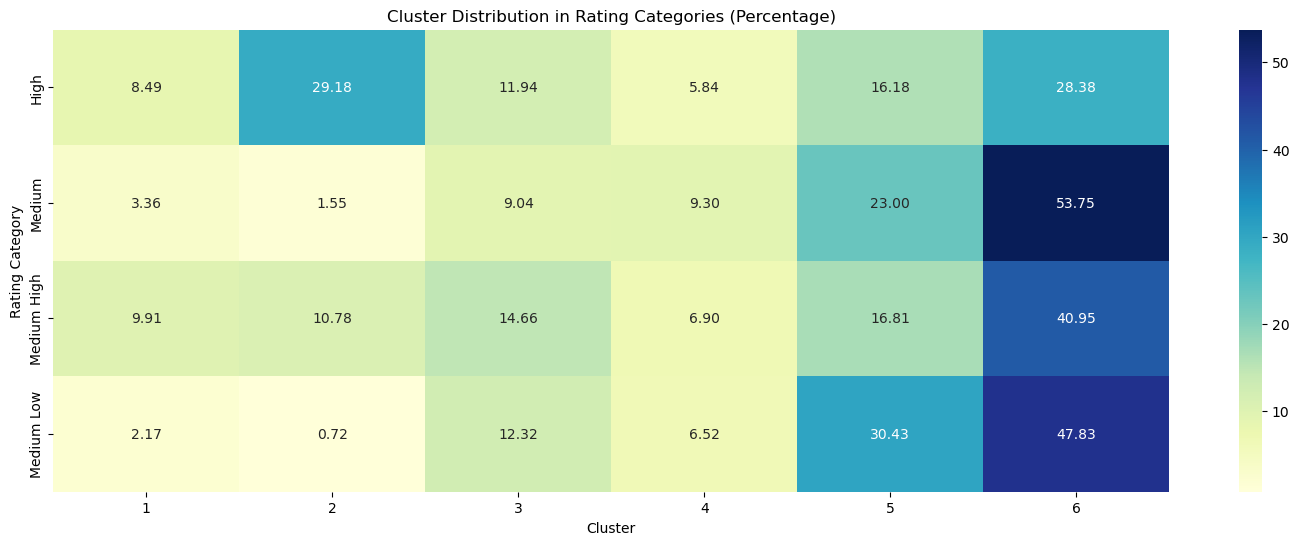


Cluster Purity by Rating Category:
cluster
1    0.414197
2    0.690947
3    0.305607
4    0.325755
5    0.352161
6    0.314487
dtype: float64


In [141]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Calcola la distribuzione delle categorie di rating per cluster
rating_distribution = ts_g.groupby(['rating_category', 'cluster']).size().unstack(fill_value=0)

# Converte i conteggi in percentuali rispetto al totale per ciascuna categoria di rating
rating_distribution_percentage = rating_distribution.div(rating_distribution.sum(axis=1), axis=0) * 100

# Crea la heatmap
plt.figure(figsize=(18, 6))
sns.heatmap(rating_distribution_percentage, annot=True, fmt='.2f', cmap='YlGnBu')
plt.title('Cluster Distribution in Rating Categories (Percentage)')
plt.xlabel('Cluster')
plt.ylabel('Rating Category')
plt.show()

# Calculate cluster purity for rating category
rating_purity = rating_distribution_percentage.max(axis=0) / rating_distribution_percentage.sum(axis=0)

print("\nCluster Purity by Rating Category:")
print(rating_purity)

In [142]:
rating_purity.mean()

0.4005257914414993

In [127]:
import pandas as pd
from ast import literal_eval

ts_gen = ts_g

# Convert the genre column from string representation of list to actual list
ts_gen['genre'] = ts_gen['genre'].apply(literal_eval)

# Create a new DataFrame with binary columns for each genre
genres = set(g for sublist in ts_gen['genre'] for g in sublist)
for genre in genres:
    ts_gen[genre] = ts_gen['genre'].apply(lambda x: 1 if genre in x else 0)

# Drop the original genre column
ts_gen = ts_gen.drop(columns=['genre'])

ts_gen

,id,0,1,2,3,4,5,6,7,8,...,Drama,Adventure,Biography,Musical,Music,Fantasy,Action,Horror,Comedy,Mystery
0,tt0062622,2.482691,3.103747,3.559498,3.661604,3.738018,1.922693,0.504129,0.340080,0.176768,...,0,1,0,0,0,0,0,0,0,0
1,tt0064816,0.755653,1.473569,2.093652,2.228891,2.382833,2.080704,1.754117,0.863556,-0.173753,...,1,0,0,0,0,0,0,0,0,0
2,tt0088178,2.558031,2.242591,1.877203,1.821367,1.766713,1.143775,0.274846,0.323123,0.381604,...,0,0,0,0,1,0,0,0,0,0
3,tt0145487,3.420437,1.788017,-0.158955,-0.137211,-0.107383,-0.125422,-0.147817,-0.386230,-0.579652,...,0,1,0,0,0,0,1,0,0,0
4,tt0359950,4.115150,3.170309,2.253611,2.175913,2.102388,2.173167,2.239405,1.816339,1.449363,...,1,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1129,tt9731534,4.128610,4.057376,3.979631,3.405842,2.640363,1.627851,0.697029,0.793137,0.894179,...,0,0,0,0,0,0,0,1,0,1
1130,tt9735462,2.892057,2.954792,3.024155,2.684483,2.358581,1.641533,0.477102,1.220981,2.835563,...,1,0,1,0,0,0,0,0,1,0
1131,tt9764362,4.070935,3.795272,3.539188,2.720534,2.070322,1.348375,0.422882,0.576563,0.792893,...,0,0,0,0,0,0,0,1,1,0
1132,tt9784798,2.690397,3.255328,3.753638,4.040744,4.428799,2.689321,0.468972,0.244270,-0.019875,...,1,0,1,0,0,0,0,0,0,0


In [128]:

ts_gen.iloc[:, -22:]


,Sport,Western,War,Crime,Short,Animation,Family,Thriller,Sci-Fi,History,...,Drama,Adventure,Biography,Musical,Music,Fantasy,Action,Horror,Comedy,Mystery
0,0,0,0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1129,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,1
1130,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,1,0
1131,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,1,0
1132,0,0,0,0,0,0,0,0,0,1,...,1,0,1,0,0,0,0,0,0,0


In [129]:
ts_gen.columns

Index(['id', '0', '1', '2', '3', '4', '5', '6', '7', '8',
       ...
       'Drama', 'Adventure', 'Biography', 'Musical', 'Music', 'Fantasy',
       'Action', 'Horror', 'Comedy', 'Mystery'],
      dtype='object', length=126)

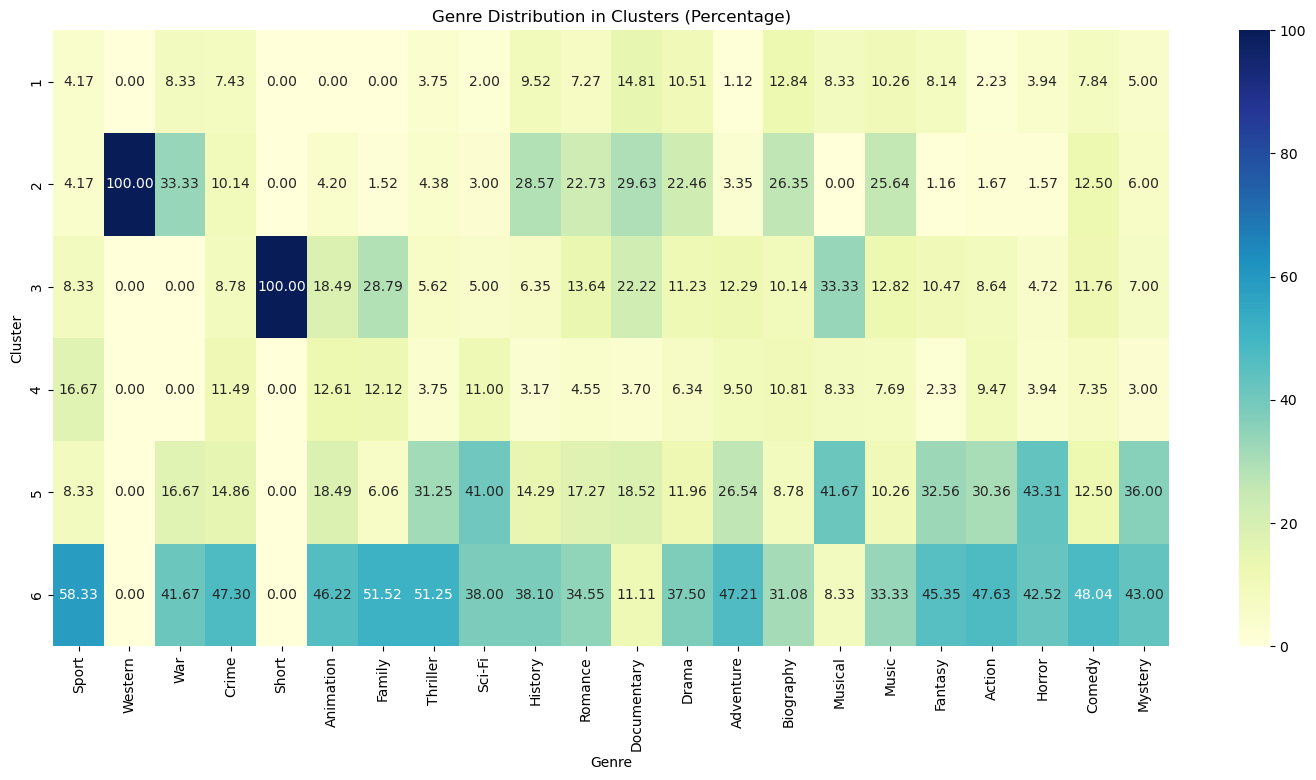

Cluster Purity by Genre:
cluster
1    0.116200
2    0.292080
3    0.294442
4    0.112755
5    0.098276
6    0.072732
dtype: float64


In [130]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Calcola la distribuzione dei generi per cluster
genre_columns = ts_gen.columns[-22:]
genre_distribution = ts_gen.groupby('cluster')[genre_columns].sum()

# Converte i conteggi in percentuali rispetto al totale per ciascun genere
genre_distribution_percentage = genre_distribution.div(genre_distribution.sum(axis=0), axis=1) * 100

# Crea la heatmap
plt.figure(figsize=(18, 8))
sns.heatmap(genre_distribution_percentage, annot=True, fmt='.2f', cmap='YlGnBu')
plt.title('Genre Distribution in Clusters (Percentage)')
plt.xlabel('Genre')
plt.ylabel('Cluster')
plt.show()

# Calcola la purity per ciascun genere
genre_purity = genre_distribution_percentage.max(axis=1) / genre_distribution_percentage.sum(axis=1)

print("Cluster Purity by Genre:")
print(genre_purity)

In [131]:
genre_purity.mean()

0.1644140958668049

Con la pca le purity aumentano del 3%.  
  
Anche se clustering con kmeans ha portato a una purity leggermente piu alta comunque sembra che la feature base con pca abbia le classi distribuite meglio all'interno dei cluster.

In [143]:
ts_g

,id,0,1,2,3,4,5,6,7,8,...,Drama,Adventure,Biography,Musical,Music,Fantasy,Action,Horror,Comedy,Mystery
0,tt0062622,2.482691,3.103747,3.559498,3.661604,3.738018,1.922693,0.504129,0.340080,0.176768,...,0,1,0,0,0,0,0,0,0,0
1,tt0064816,0.755653,1.473569,2.093652,2.228891,2.382833,2.080704,1.754117,0.863556,-0.173753,...,1,0,0,0,0,0,0,0,0,0
2,tt0088178,2.558031,2.242591,1.877203,1.821367,1.766713,1.143775,0.274846,0.323123,0.381604,...,0,0,0,0,1,0,0,0,0,0
3,tt0145487,3.420437,1.788017,-0.158955,-0.137211,-0.107383,-0.125422,-0.147817,-0.386230,-0.579652,...,0,1,0,0,0,0,1,0,0,0
4,tt0359950,4.115150,3.170309,2.253611,2.175913,2.102388,2.173167,2.239405,1.816339,1.449363,...,1,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1129,tt9731534,4.128610,4.057376,3.979631,3.405842,2.640363,1.627851,0.697029,0.793137,0.894179,...,0,0,0,0,0,0,0,1,0,1
1130,tt9735462,2.892057,2.954792,3.024155,2.684483,2.358581,1.641533,0.477102,1.220981,2.835563,...,1,0,1,0,0,0,0,0,1,0
1131,tt9764362,4.070935,3.795272,3.539188,2.720534,2.070322,1.348375,0.422882,0.576563,0.792893,...,0,0,0,0,0,0,0,1,1,0
1132,tt9784798,2.690397,3.255328,3.753638,4.040744,4.428799,2.689321,0.468972,0.244270,-0.019875,...,1,0,1,0,0,0,0,0,0,0


In [146]:
# Calcola la media di ciascuna serie temporale, escludendo le colonne non numeriche
ts_g['mean'] = ts_g.drop(columns=['id', 'rating', 'genre', 'rating_category', 'cluster']).mean(axis=1)

# Statistiche descrittive delle medie delle serie temporali per cluster
cluster_stats_mean = ts_g.groupby('cluster')['mean'].describe()

# Statistiche descrittive del rating per cluster
cluster_stats_rating = ts_g.groupby('cluster')['rating'].describe()

# Visualizza i risultati
print("Statistiche delle medie delle serie temporali per cluster:")
print(cluster_stats_mean)

print("\nStatistiche del rating per cluster:")
print(cluster_stats_rating)

Statistiche delle medie delle serie temporali per cluster:
         count          mean           std           min           25%  \
cluster                                                                  
1         71.0 -7.048005e-02  4.408378e-02 -1.434990e-01 -1.021359e-01   
2        142.0 -1.111148e-01  6.302619e-02 -2.210823e-01 -1.529166e-01   
3        131.0  1.998392e-01  8.193862e-02 -3.203878e-02  1.697046e-01   
4         83.0  2.937409e-17  1.362222e-16 -3.408385e-16 -5.551115e-17   
5        231.0  2.684241e-17  9.885532e-17 -2.275957e-16 -4.662937e-17   
6        476.0  7.846198e-18  1.117013e-16 -4.396483e-16 -7.133183e-17   

                  50%           75%           max  
cluster                                            
1       -7.461352e-02 -5.446574e-02  6.130916e-02  
2       -1.295302e-01 -9.082824e-02  5.747155e-02  
3        2.214781e-01  2.505889e-01  3.433632e-01  
4        3.441691e-17  1.065814e-16  5.173639e-16  
5        2.331468e-17  9.270362e-17 

In [147]:
cluster_stats_mean

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
1,71.0,-7.048005e-02,4.408378e-02,-1.434990e-01,-1.021359e-01,-7.461352e-02,-5.446574e-02,6.130916e-02
2,142.0,-1.111148e-01,6.302619e-02,-2.210823e-01,-1.529166e-01,-1.295302e-01,-9.082824e-02,5.747155e-02
3,131.0,1.998392e-01,8.193862e-02,-3.203878e-02,1.697046e-01,2.214781e-01,2.505889e-01,3.433632e-01
4,83.0,2.937409e-17,1.362222e-16,-3.408385e-16,-5.551115e-17,3.441691e-17,1.065814e-16,5.173639e-16
5,231.0,2.684241e-17,9.885532e-17,-2.275957e-16,-4.662937e-17,2.331468e-17,9.270362e-17,3.030909e-16
6,476.0,7.846198e-18,1.117013e-16,-4.396483e-16,-7.133183e-17,6.661338e-18,8.104628e-17,3.208545e-16


In [148]:
cluster_stats_rating

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
1,71.0,6.932394,0.667570,4.8,6.60,6.9,7.4,8.3
2,142.0,7.340141,0.488747,5.3,7.10,7.4,7.6,8.5
3,131.0,6.693130,0.920300,4.3,6.20,6.8,7.3,8.7
4,83.0,6.463855,0.926780,2.8,5.90,6.5,7.1,8.7
5,231.0,6.403030,0.945810,3.3,5.85,6.4,7.1,8.5
6,476.0,6.387395,0.856534,3.1,5.90,6.4,7.0,8.5
